### <font color='DarkCyan'>Описание задания</font>

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
Ваша задача — проанализировать данные АB-теста. 

### <font color='DarkCyan'>Что у нас есть:</font>
Данные с <b>2022-10-03</b> по <b>'2022-10-09'</b> включительно.  
Группа <b>1</b> - контрольная.  
Группа <b>2</b> - экспериментальная (был использован один из новых алгоритмов рекомендации постов).

### <font color='DarkCyan'>Что нужно сделать:</font>
* Построить графики распределений. 
* Сравнить CTR в двух группах с помощью всех изученных методов анализа <i>(t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования)</i>.
* Подумать, почему результаты показали то, что показали. 
* Написать рекомендацию - стоит ли раскатывать полученные результаты на всех пользователей. 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

### <font color='DarkCyan'>Извлечение необходимых данных из базы данных</font>

Данные были извлечены из базы данных с помощью Clickhouse, ниже можно увидеть запрос

In [2]:
'''query = """SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-10-03' and '2022-10-09'
        and exp_group in (1,2)
    GROUP BY exp_group, user_id""" '''

'query = """SELECT exp_group, \n        user_id,\n        sum(action = \'like\') as likes,\n        sum(action = \'view\') as views,\n        likes/views as ctr\n    FROM {db}.feed_actions \n    WHERE toDate(time) between \'2022-10-03\' and \'2022-10-09\'\n        and exp_group in (1,2)\n    GROUP BY exp_group, user_id""" '

In [3]:
data = pd.read_csv('C:/Users/folde/Desktop/ab-test.csv')
data.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


### <font color='DarkCyan'>Визуализация распределений CTR в двух группах</font>

Text(0.5, 1.0, 'Показатель CTR внутри групп')

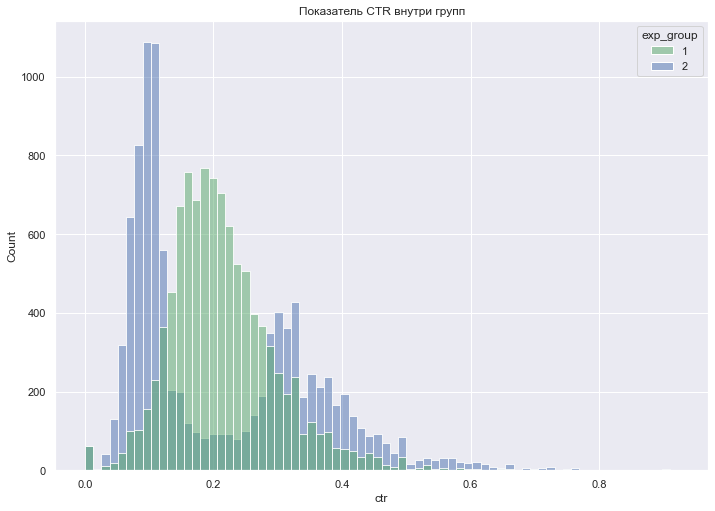

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = data, 
              x='ctr', 
              hue='exp_group', 
              palette = ['g', 'b'],
              alpha=0.5,
              kde=False)
plt.title('Показатель CTR внутри групп')

В тестовой группе распределение бимодальное, из чего следует:
* В данном случае t-test, скорее всего, покажет недостоверные результаты, поэтому он не будет использован в расчетах.
* Следует более детально изучить данные по контрольной группе. 

    Возможные причины:
    - Не был проведен АА-тест и группы в целом нельзя сравнивать;
    - Часть пользователей имела проблемы с новым функционалом или с работой приложения в целом;
    - Пользователи разделились на два лагеря (например, по ОС), где одним обновление "сильно понравилось", другим "сильно не понравилось".

### <font color='DarkCyan'>Сравнение CTR в двух группах с помощью всех изученных методов анализа </font>

Гипотезы:  
<b>Н0:</b> CTR1=CTR2  
<b>Н1:</b> CTR1 != CTR2 (CTR1 > CTR2)

### <font color='DarkCyan'>1. Манна-Уитни & Сглаженный Манна-Уитни</font>

In [5]:
print(f'P-value для CTR1 != CTR2: {st.mannwhitneyu(data[data.exp_group == 1].ctr, data[data.exp_group == 2].ctr, alternative="two-sided").pvalue}')
print(f'P-value для CTR1 > CTR2: {st.mannwhitneyu(data[data.exp_group == 1].ctr, data[data.exp_group == 2].ctr, alternative="greater").pvalue}')

P-value для CTR1 != CTR2: 6.0376484617779035e-56
P-value для CTR1 > CTR2: 3.0188242308889518e-56


In [6]:
# считаем сглаженный CTR
def smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = data[data.exp_group == 1].likes.sum()/data[data.exp_group == 1].views.sum()
global_ctr_2 = data[data.exp_group == 2].likes.sum()/data[data.exp_group == 2].views.sum()
smothed_ctr_1 = data[data.exp_group == 1].apply(lambda x: smothed_ctr(x.likes, x.views, global_ctr_1, 5), axis=1)
smothed_ctr_2 = data[data.exp_group == 2].apply(lambda x: smothed_ctr(x.likes, x.views, global_ctr_2, 5), axis=1)

print(f'P-value для CTR1 != CTR2: {st.mannwhitneyu(smothed_ctr_1, smothed_ctr_2, alternative="two-sided").pvalue}')
print(f'P-value для CTR1 > CTR2: {st.mannwhitneyu(smothed_ctr_1, smothed_ctr_2, alternative="greater").pvalue}')

P-value для CTR1 != CTR2: 1.6163964114270227e-61
P-value для CTR1 > CTR2: 8.081982057135114e-62


#### Подтвердилась гипотеза H1: CTR1 > CTR2 => отвергаем гипотезу H0 об отсутствии различий и CTR1>CTR2 

### <font color='DarkCyan'>2. Пуассоновский бутстреп для подсчета разницы в CTR</font>

- Берем выборку из группы А (у нас это $user\_id$ с его $views$ и $clicks$)
- Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее $weights_1$
- Считаем «глобальный CTR» по псевдовыборке для A*A* :

$$
globalCTR_A = \dfrac{sum(clicks_A*weights_1)}{sum(views_A*weights_1)}
$$

- Берем выборку из группы B (у нас это $user\_id$ с его $views$ и $clicks$)
- Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее $weights_2$
- Считаем «глобальный CTR» по псевдовыборке для B*B*:

$$
globalCTR_B = \dfrac{sum(clicks_B*weights_2)}{sum(views_B*weights_2)}
$$

- Считаем разницу между $globalCTR_A - globalCTR_B$ и записываем эту разность, например, в список
- Повторяем процедуру много раз, например, 2000

Таким образом, мы набираем распределение для разницы в глобальном CTR.

<AxesSubplot:ylabel='Count'>

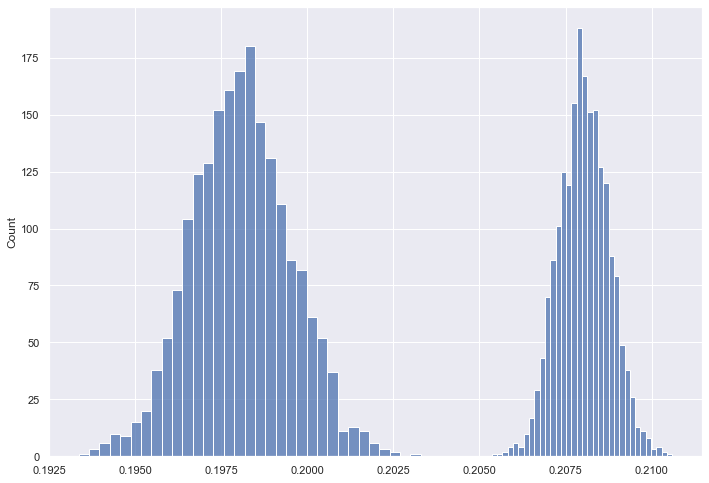

In [7]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = data[data.exp_group == 1].likes.to_numpy()
views1 = data[data.exp_group == 1].views.to_numpy()
likes2 = data[data.exp_group == 2].likes.to_numpy()
views2 = data[data.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

#### Распределение CTR в двух группах не пересекается => Отвергаем гипотезу HO и CTR1 > CTR2

<AxesSubplot:ylabel='Count'>

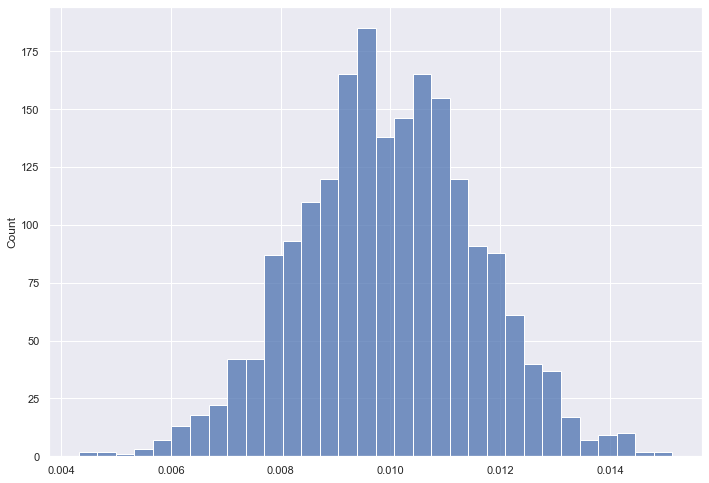

In [8]:
#Разница между глобальными CTR
sns.histplot(ctr1 - ctr2)

#### Распределение разниц глобальных CTR не пересекает 0, а значения > 0, => CTR1 > CTR2

### <font color='DarkCyan'>3. Бакетное преобразование</font>

Данные были извлечены из базы данных с помощью Clickhouse, ниже можно увидеть запрос

In [10]:
''' """
    SELECT exp_group, bucket,
        sum(likes)/sum(views) as bucket_ctr,
        quantileExact(0.9)(ctr) as ctr9
    FROM (SELECT exp_group, 
            xxHash64(user_id)%50 as bucket,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM {db}.feed_actions 
        WHERE toDate(time) between '2022-10-03' and '2022-10-09'
            and exp_group in (1,2)
        GROUP BY exp_group, bucket, user_id)
    GROUP BY exp_group, bucket
""" '''

' """\n    SELECT exp_group, bucket,\n        sum(likes)/sum(views) as bucket_ctr,\n        quantileExact(0.9)(ctr) as ctr9\n    FROM (SELECT exp_group, \n            xxHash64(user_id)%50 as bucket,\n            user_id,\n            sum(action = \'like\') as likes,\n            sum(action = \'view\') as views,\n            likes/views as ctr\n        FROM {db}.feed_actions \n        WHERE toDate(time) between \'2022-10-03\' and \'2022-10-09\'\n            and exp_group in (1,2)\n        GROUP BY exp_group, bucket, user_id)\n    GROUP BY exp_group, bucket\n""" '

In [11]:
data_2 = pd.read_csv('C:/Users/folde/Desktop/ab-test-baketnoe.csv')
data_2.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314


In [12]:
print(f'P-value для CTR1 != CTR2: {st.mannwhitneyu(data_2[data_2.exp_group == 1].bucket_ctr, data_2[data_2.exp_group == 2].bucket_ctr, alternative = "two-sided").pvalue}')
print(f'P-value для CTR1 > CTR2: {st.mannwhitneyu(data_2[data_2.exp_group == 1].bucket_ctr, data_2[data_2.exp_group == 2].bucket_ctr, alternative = "greater").pvalue}')

P-value для CTR1 != CTR2: 2.859963936492646e-07
P-value для CTR1 > CTR2: 1.429981968246323e-07


#### Подтвердилась гипотеза H1: CTR1 > CTR2 => отвергаем гипотезу H0 об отсутствии различий и CTR1>CTR2 

### <font color='DarkCyan'>Выводы</font>

По результатам исследования <i>мы отвергаем гипотезу H0 об отсутствии различий</i>. Более того, мы выяснили, что <b>CTR1>CTR2</b>.  
Из этого можно было бы сделать вывод, что раскатывать обновление категорически не стоит.  
<b>Но!</b>  
Так как на графике распределений CTR во второй группе видно 2 вершины, необходимо провести углубленный анализ данной группы, так как возможны следующие причины:  
   * Не был проведен АА-тест и группы в целом нельзя сравнивать;  
   * Часть пользователей имела проблемы с новым функционалом или с работой приложения в целом;  
   * Пользователи разделились на два лагеря (например, по ОС), где одним обновление "сильно понравилось", другим "сильно не понравилось".

